In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict, Counter

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

metadata = pd.read_csv("./metadata.csv", index_col=0)
datacat = pd.read_csv("./catalogs_subset_stats (1).csv", names=["ark", "filename", "year", "folio"])

datacat.filename = datacat.filename.apply(lambda x: (re.findall("(12148_[a-z0-9]+)_", x) or [x])[0])

In [4]:


subsets = defaultdict(list)

for file in glob.glob(".data/*/*/images/*.jpg"):
    _, _, _, subset, _, _, filename = file.split("/")
    year = 0
    simpler_subset = {
        "administrative-report": "Admin",
        "romans-19": "Romans19",
        "picard": "Others",
        "typewriter": "Others",
        "magazine-tech": "Tech. Magazines",
        "persee": "Persée",
        "these": "These",
        "catalogue": "Catalogue",
        "theatre": "Theatre",
        "monographies": "Monographs"
    }.get(subset, "Others")
    
    if subset == "administrative-report":
        year = int(re.findall(r"govreport_[a-zA-Z\-]+_(\d{4})", filename)[0])
    elif subset == "romans-19":
        year = int(filename.split("_")[0])
    elif subset == "picard":
        year = int(filename.split("_")[2])
    elif subset == "typewriter":
        year = int(filename.split("_")[1])
    elif subset == "magazine-tech":
        year = int(filename.split("_")[1].replace("x", "0").replace("unk", "0"))
    elif subset == "persee":
        if matches := re.findall(r"(19[0-9]{2}|20[0-9]{2})[A-Z0-9]{8}", filename):
            year = int(matches[0])
        elif matches := re.findall(r"^[a-z0-9]+_[\dXx]{4}(?:[\-\d])[\dXx]{4}_(1[89][0-9]{2}|20[0-9]{2})_", filename):
            year = int(matches[0])
        else:
            print(filename)
    elif subset == "these":
        # print(filename, re.search(r"^(19[0-9]{2}|20[0-9]{2})[A-Z0-9]{8}", filename))
        if matches := re.findall(r"(19[0-9]{2}|20[0-9]{2})[A-Z0-9]{8}", filename):
            year = int(matches[0])
        # year = int(filename.split("_")[1].replace("x", "0").replace("unk", "0"))
    elif subset == "theatre":
        try:
            year = int([el for el in re.findall(r"(?:theatre_(\d{4}))|(?:theatre_b[a-z0-9]+_(\d{4}))", filename)[0] if el][0])
        except Exception:
            year = 1601  # Missing years
    if year == 0:
        ser = metadata[(metadata.index == filename) & (metadata.year > 0)].year
        if ser.any():
            year = int(ser.iloc[0])
        # else:
        #     print(subset, filename)
    
    if subset == "catalogue":
        if match := re.findall("(12148-[a-z0-9]+)_", filename):
            ser = datacat[(datacat.filename == match[0].replace("-", "_"))].year
            
            if ser.any():
                year = int(ser.iloc[0].split("-")[0])
    subsets[subset].append((filename, year, simpler_subset))

Le_Prince_Dgem_chronique_dauphinoise_-Arnaud_Victor_bpt6k5468703r_11.jpg
Le_Prince_Dgem_chronique_dauphinoise_-Arnaud_Victor_bpt6k5468703r_8.jpg


In [5]:
df = pd.DataFrame([
    (subset, filename, year, simpler_subset)
    for subset, files in subsets.items()
    for filename, year, simpler_subset in files
], columns=["Full Subset", "Filename", "Year", "Subset"])


Text(0, 0.5, 'Documents')

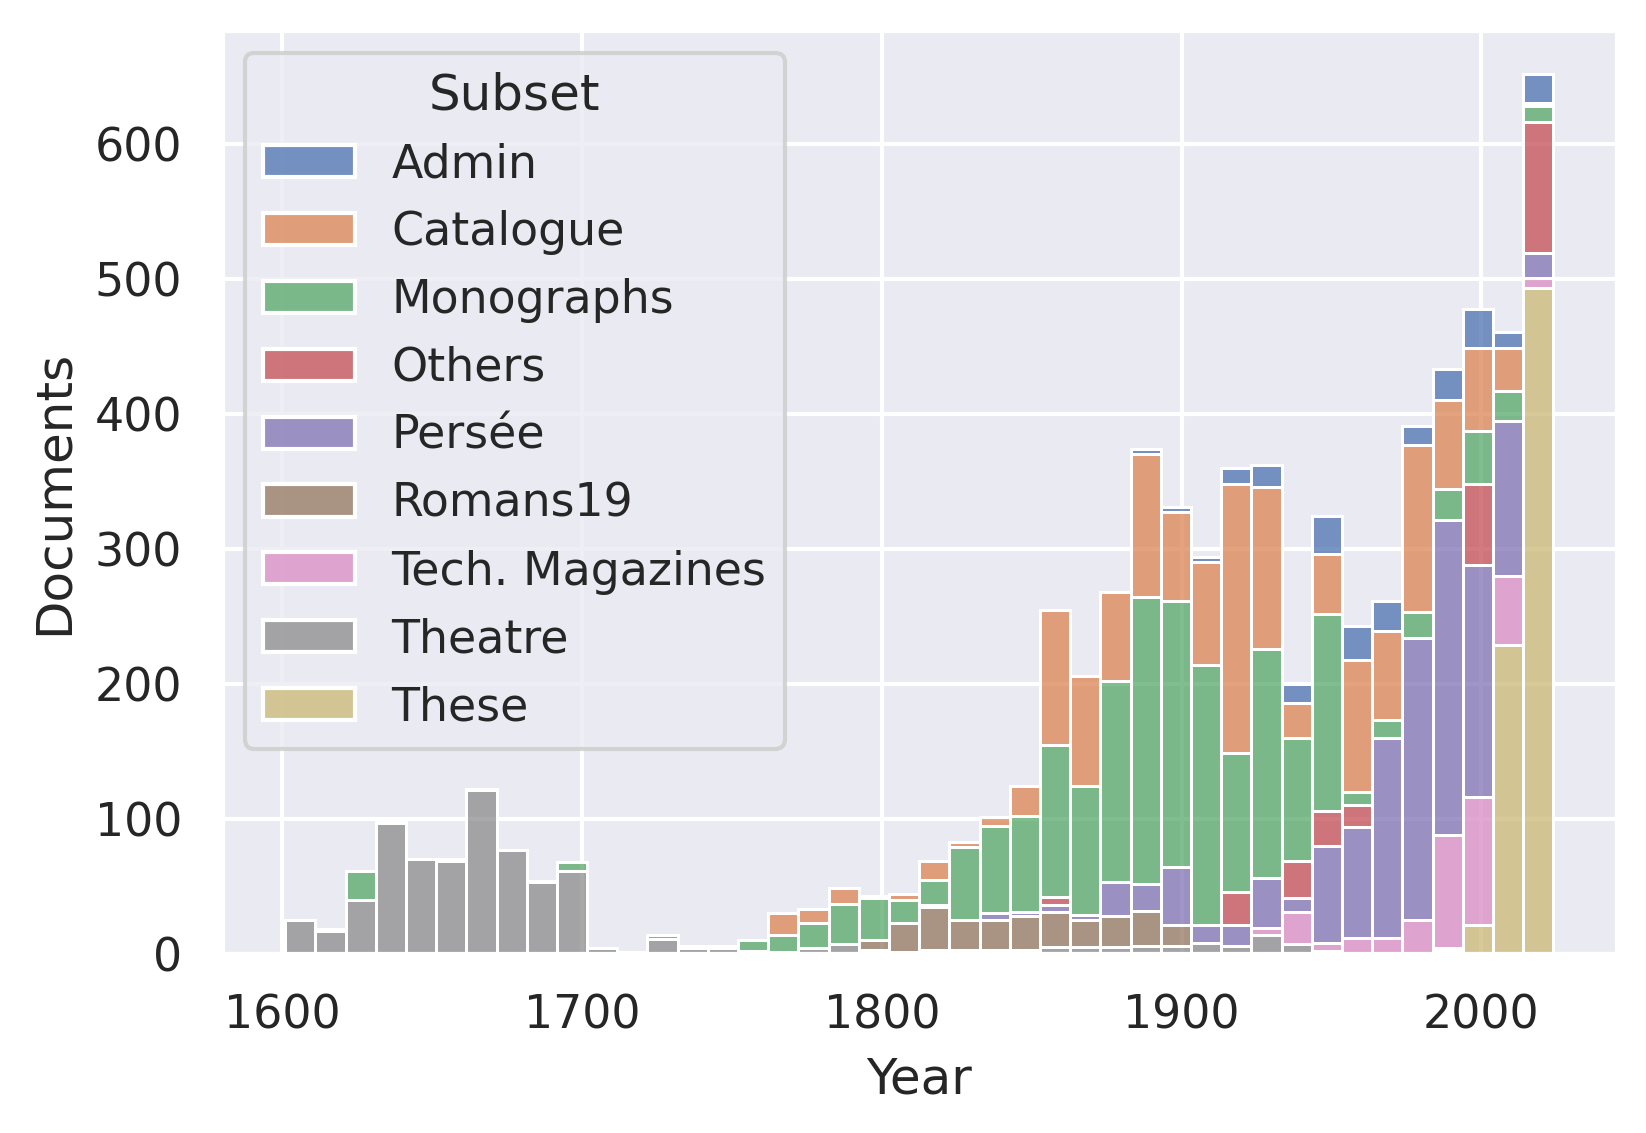

In [6]:
plt.figure(dpi=300, figsize=(6, 4))
ax = sns.histplot(data=df[df.Year>1600].sort_values("Subset"), x="Year", hue="Subset", multiple="stack", bins=42)
ax.set_ylabel("Documents")

In [7]:
import yaml
data = []

with open("./training-set/data.yaml") as f:
    labels = yaml.safe_load(f)["names"]

zones = defaultdict(Counter)

split = 50

for file in glob.glob("../LADaS/data/*/*/labels/*.txt"):
    *_, filename = file.split("/")
    jpg = filename.replace(".txt", ".jpg")
    year = df[df.Filename == jpg].Year.iloc[0]
    if year < 1600:
        continue
    with open(file) as f:
        for line in f:
            zones[labels[int(line.split()[0])]][year // split * split] += 1


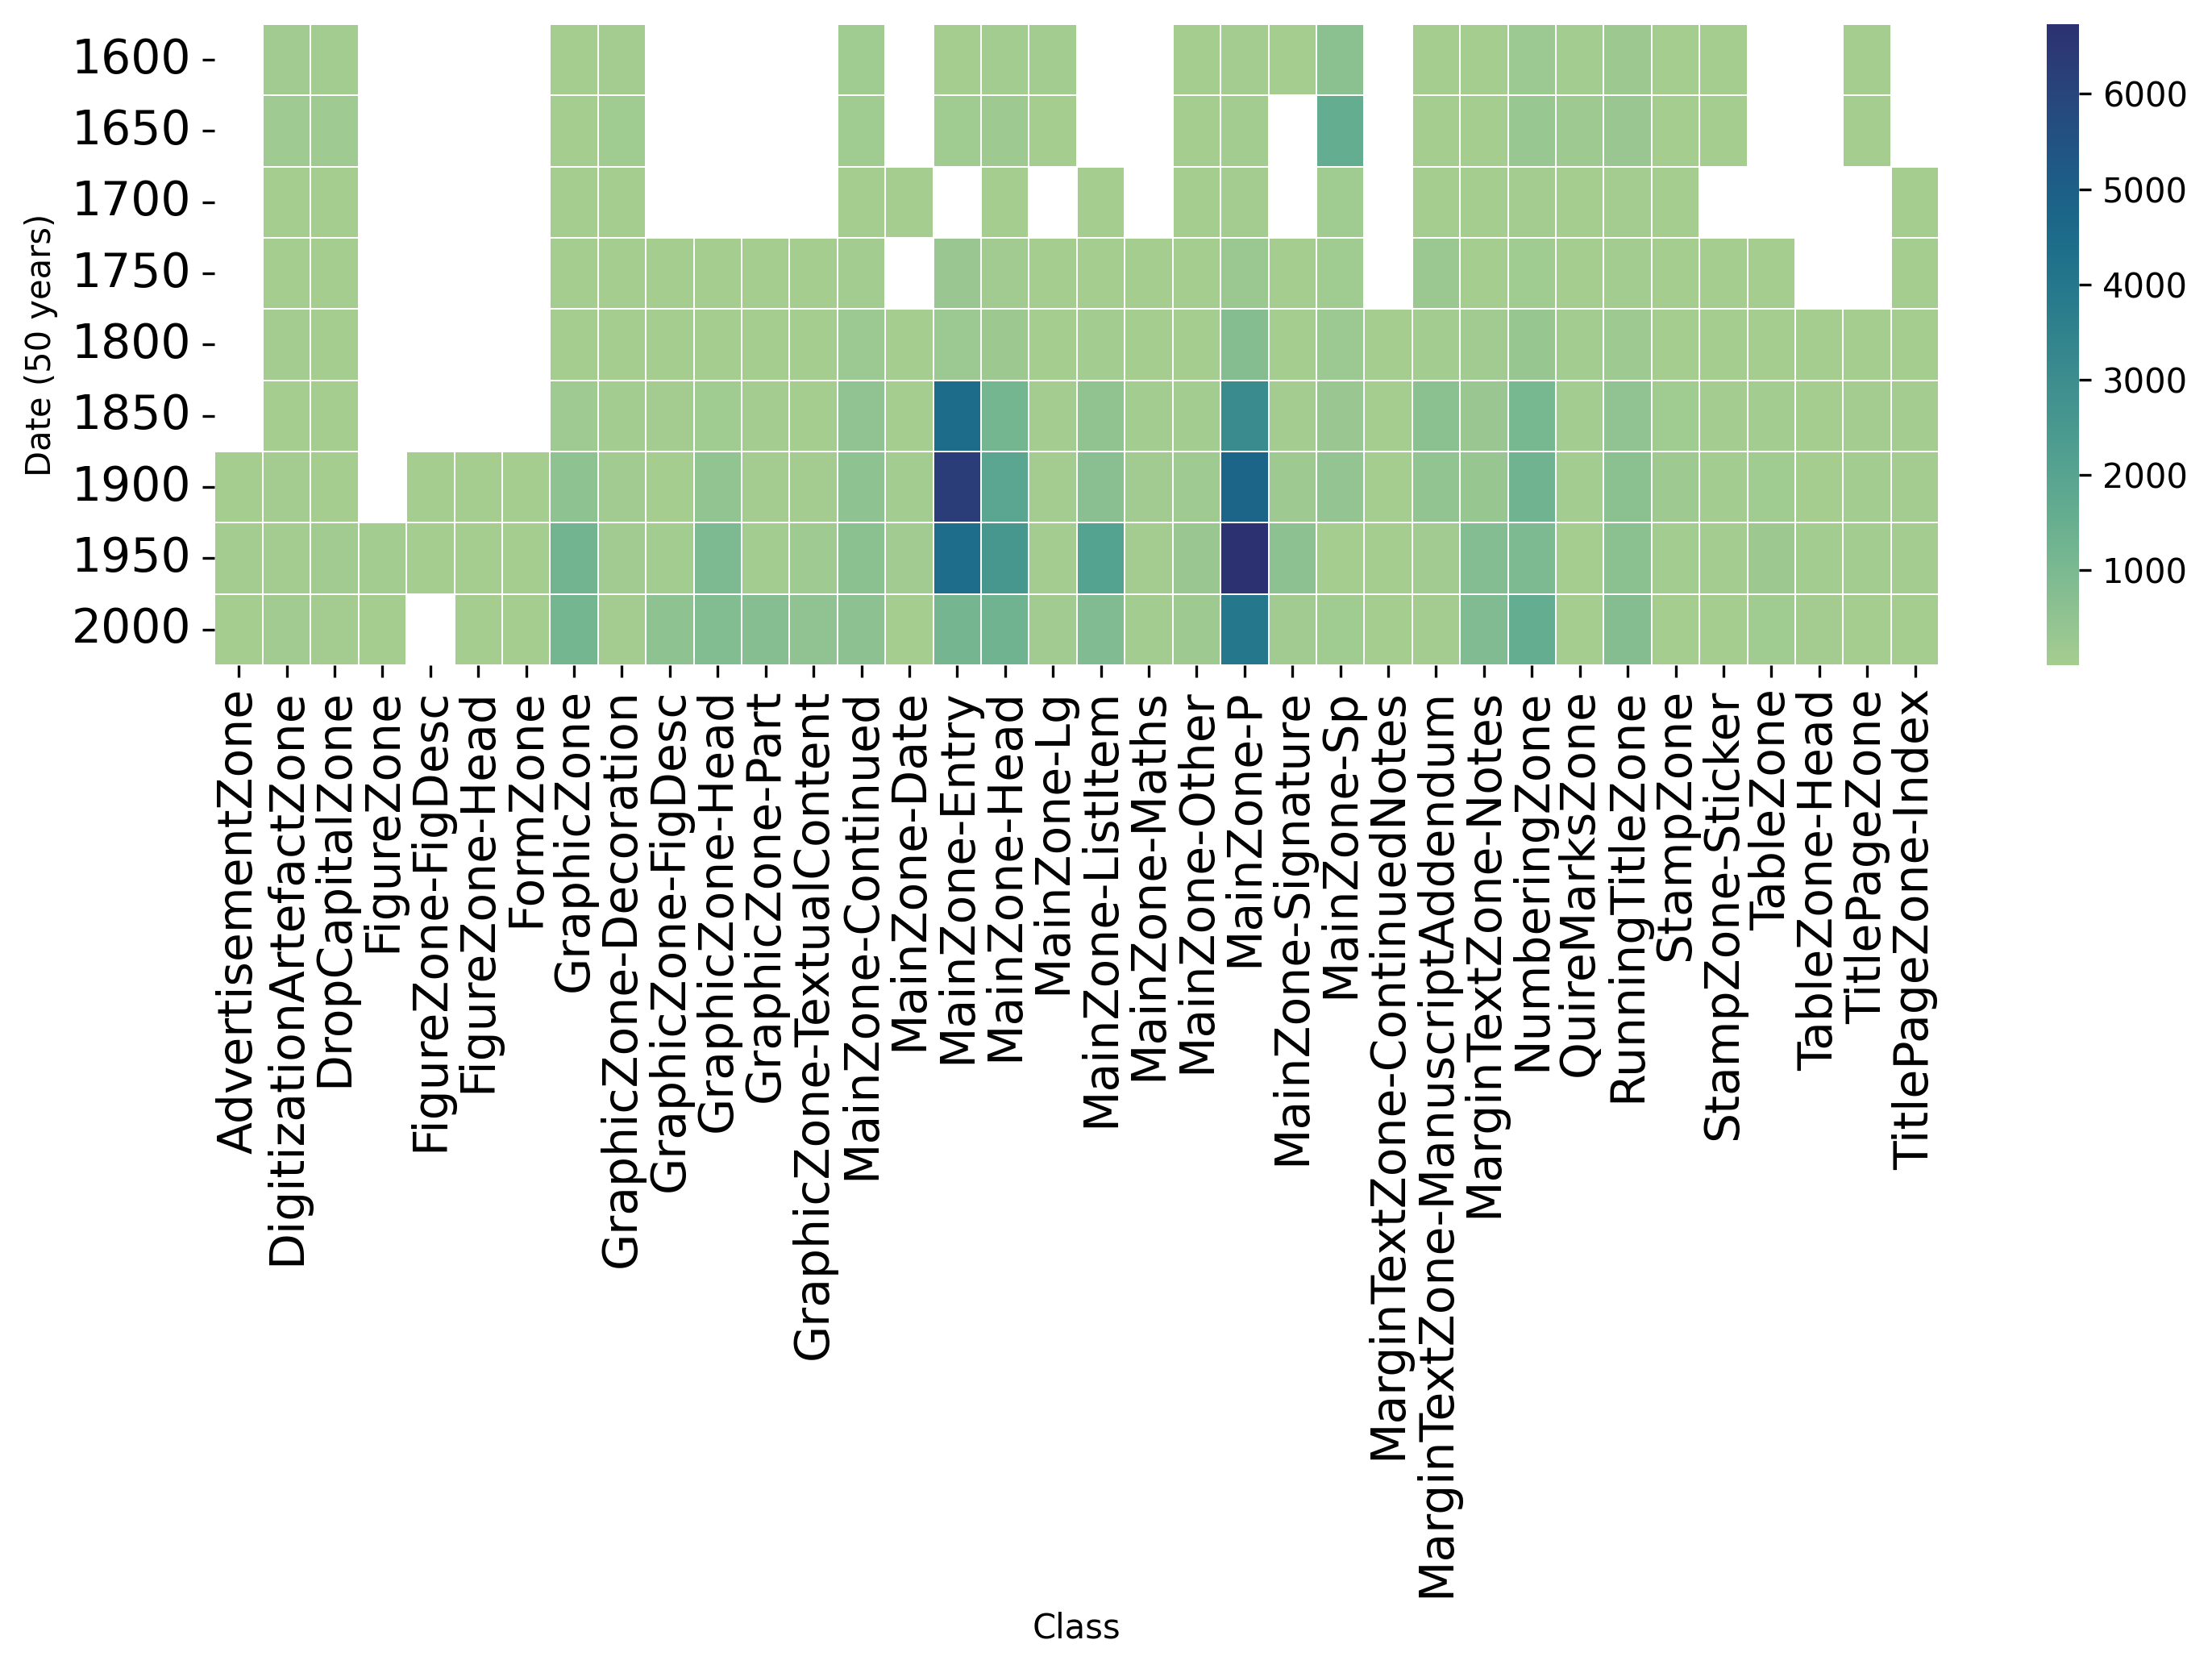

In [8]:
regions = pd.DataFrame(
    [
        [zone.replace("GraphicZone-Maths", "MainZone-Maths").replace("MainZone-Form", "FormZone"), year, count]
        for zone, items in zones.items()
        for year, count in items.items()
    ],
    columns=["Class", "Year", "Instances"]
)
sns.reset_defaults()
fig = plt.figure(dpi=300, figsize=(10, 7))
ax = sns.heatmap(
    data=regions.sort_values("Class").pivot(columns="Class", index="Year", values="Instances"),
    linewidth=.1,
    cbar=True, cmap="crest", #cbar_kws={"shrink": 0.5},
)
ax.set_ylabel("Date (50 years)")
ax.tick_params(labelsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
fig

In [7]:
regions.Instances.sum()

81766